In [4]:


                            # Fraud Detection in Financial Transactions

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import uuid

# Generate synthetic data
def generate_transactions(num_records=10000, fraud_ratio=0.01):
    data = []

    # Generate date range for last 90 days
    end_date = datetime.now()
    start_date = end_date - timedelta(days=90)

    for _ in range(num_records):
        is_fraud = np.random.choice([0, 1], p=[1-fraud_ratio, fraud_ratio])
        amount = abs(np.random.normal(100, 50))

        if is_fraud:
            amount *= random.uniform(5, 20)
            hour = random.choice([1, 2, 3, 4, 22, 23])
            country = random.choice(['RU', 'CN', 'NG', 'BR', 'IN'])
        else:
            hour = random.randint(8, 20)
            country = random.choice(['US', 'UK', 'CA', 'AU', 'DE', 'FR'])

        # Create transaction datetime
        transaction_time = start_date + timedelta(
            seconds=random.randint(0, int((end_date - start_date).total_seconds())))
        transaction_time = transaction_time.replace(hour=hour)

        # Generate fake values
        merchant_category = random.choice(['groceries', 'electronics', 'clothing', 'restaurant', 'travel', 'utilities'])
        customer_age = random.randint(18, 80)
        customer_income = random.randint(20000, 150000)
        days_since_last = random.expovariate(1/7)

        data.append([
            transaction_time,
            str(uuid.uuid4()),  # transaction_id
            ''.join([str(random.randint(0, 9)) for _ in range(16)]),  # card_number
            amount,
            merchant_category,
            country,
            customer_age,
            customer_income,
            days_since_last,
            is_fraud
        ])

    df = pd.DataFrame(data, columns=[
        'timestamp',
        'transaction_id',
        'card_number',
        'amount',
        'merchant_category',
        'country',
        'customer_age',
        'customer_income',
        'days_since_last_transaction',
        'is_fraud'
    ])

    return df

# Generate and save dataset
transactions_df = generate_transactions(num_records=50000, fraud_ratio=0.01)
transactions_df.to_csv('financial_transactions.csv', index=False)
print("Dataset generated successfully!")

Dataset generated successfully!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   timestamp                    50000 non-null  datetime64[ns]
 1   transaction_id               50000 non-null  object        
 2   card_number                  50000 non-null  int64         
 3   amount                       50000 non-null  float64       
 4   merchant_category            50000 non-null  object        
 5   country                      50000 non-null  object        
 6   customer_age                 50000 non-null  int64         
 7   customer_income              50000 non-null  int64         
 8   days_since_last_transaction  50000 non-null  float64       
 9   is_fraud                     50000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 3.8+ MB
None

Fraud distribution:
is_f

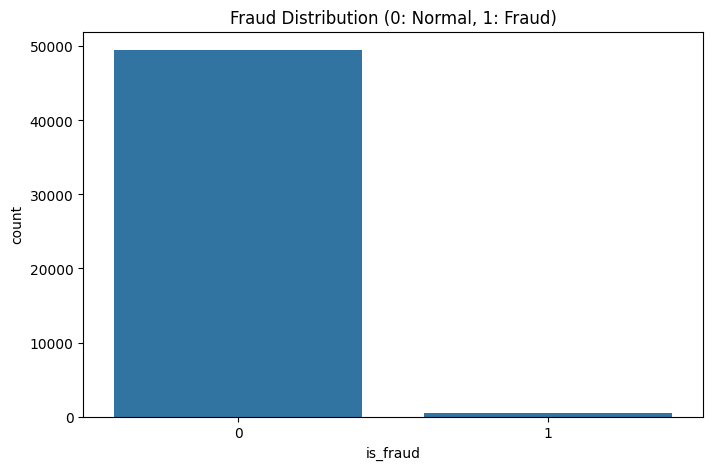

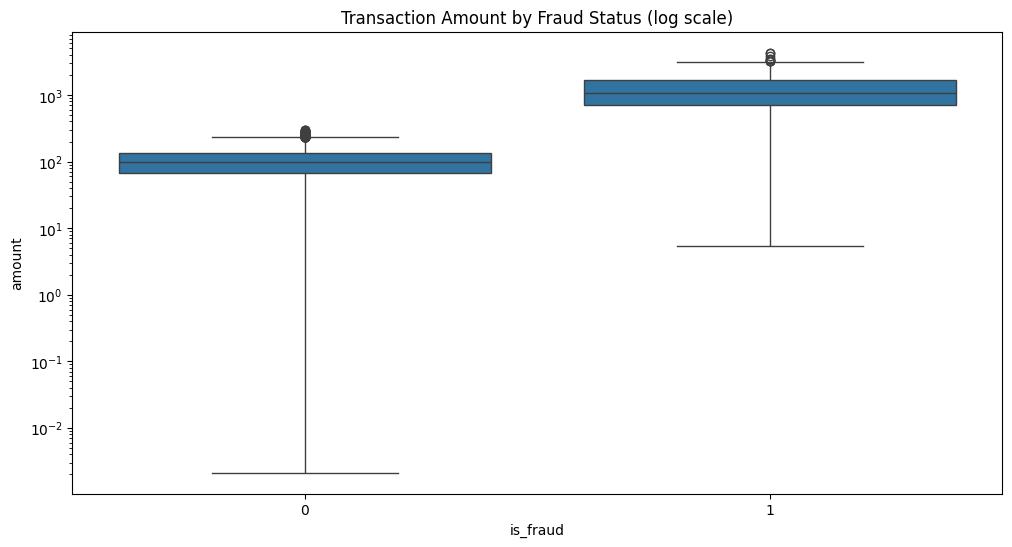

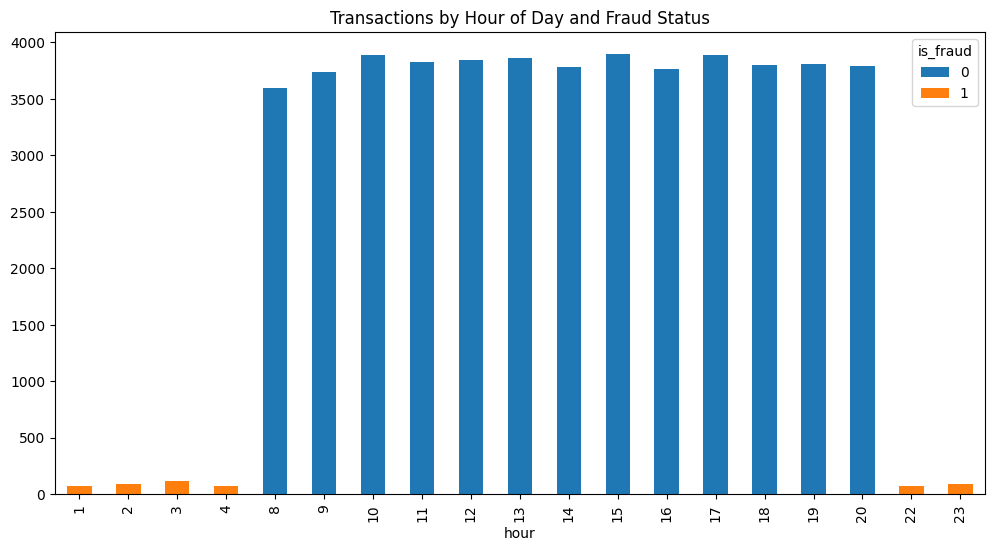

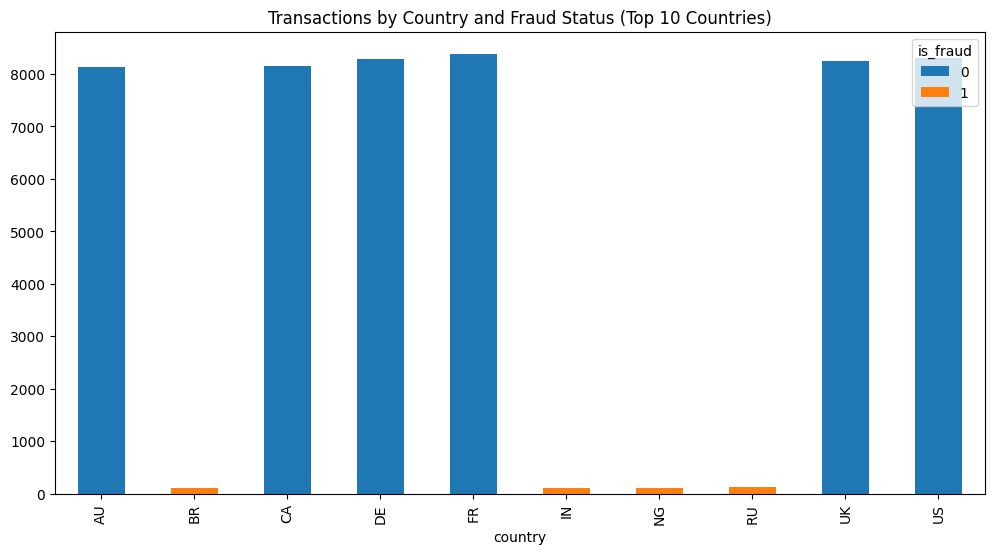

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import tensorflow as tf
from tensorflow.keras import layers, models
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load the dataset
df = pd.read_csv('financial_transactions.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Basic info
print(df.info())
print("\nFraud distribution:")
print(df['is_fraud'].value_counts(normalize=True))

# Visualize fraud ratio
plt.figure(figsize=(8, 5))
sns.countplot(x='is_fraud', data=df)
plt.title('Fraud Distribution (0: Normal, 1: Fraud)')
plt.show()

# Transaction amount distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_fraud', y='amount', data=df)
plt.yscale('log')
plt.title('Transaction Amount by Fraud Status (log scale)')
plt.show()

# Fraud by hour of day
df['hour'] = df['timestamp'].dt.hour
fraud_by_hour = df.groupby(['hour', 'is_fraud']).size().unstack()
fraud_by_hour.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Transactions by Hour of Day and Fraud Status')
plt.show()

# Fraud by country
top_countries = df['country'].value_counts().index[:10]
fraud_by_country = df[df['country'].isin(top_countries)].groupby(['country', 'is_fraud']).size().unstack()
fraud_by_country.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Transactions by Country and Fraud Status (Top 10 Countries)')
plt.show()

In [7]:
# Feature engineering
df['amount_log'] = np.log1p(df['amount'])
df['transaction_month'] = df['timestamp'].dt.month
df['transaction_day'] = df['timestamp'].dt.day
df['transaction_dow'] = df['timestamp'].dt.dayofweek

# Select features
features = ['amount_log', 'customer_age', 'customer_income', 'days_since_last_transaction',
            'hour', 'transaction_month', 'transaction_day', 'transaction_dow',
            'merchant_category', 'country']

X = df[features]
y = df['is_fraud']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# Preprocessing pipeline
numeric_features = ['amount_log', 'customer_age', 'customer_income',
                   'days_since_last_transaction', 'hour', 'transaction_month',
                   'transaction_day', 'transaction_dow']
categorical_features = ['merchant_category', 'country']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply SMOTE for class imbalance
smote = SMOTE(random_state=42, sampling_strategy=0.5)  # Balance to 1:2 ratio

In [9]:
from imblearn.pipeline import Pipeline as imbPipeline

# Isolation Forest with corrected pipeline
iso_pipe = imbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
    ('classifier', IsolationForest(
        n_estimators=150,
        max_samples='auto',
        contamination=0.01,
        random_state=42,
        verbose=1
    ))
])

# Fit and predict
iso_pipe.fit(X_train, y_train)
iso_preds = iso_pipe.predict(X_test)
iso_preds = np.where(iso_preds == -1, 1, 0)  # Convert to 0/1

# Evaluation
print("Isolation Forest Results:")
print(classification_report(y_test, iso_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, iso_preds))
print("ROC AUC:", roc_auc_score(y_test, iso_preds))

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Isolation Forest Results:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14849
           1       0.09      0.05      0.06       151

    accuracy                           0.99     15000
   macro avg       0.54      0.52      0.53     15000
weighted avg       0.98      0.99      0.98     15000

Confusion Matrix:
[[14776    73]
 [  144     7]]
ROC AUC: 0.5207207299619704


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished


In [11]:
# Step 5: Modeling - Autoencoder (Corrected)
from sklearn.preprocessing import MinMaxScaler

# Prepare data for autoencoder
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)  # Already a numpy array
X_test_processed = preprocessor.transform(X_test)    # Already a numpy array

# Normalize data between 0-1 (remove .toarray() call)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)  # Removed .toarray()
X_test_scaled = scaler.transform(X_test_processed)       # Removed .toarray()

# Build autoencoder (rest remains the same)
input_dim = X_train_scaled.shape[1]
encoding_dim = 32

input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(encoding_dim, activation="relu")(input_layer)
encoder = layers.Dense(encoding_dim // 2, activation="relu")(encoder)
decoder = layers.Dense(encoding_dim, activation='relu')(encoder)
decoder = layers.Dense(input_dim, activation='sigmoid')(decoder)
autoencoder = models.Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam',
                   loss='mean_squared_error',
                   metrics=['mse'])

# Train
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test_scaled, X_test_scaled),
    verbose=1)

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.1517 - mse: 0.1517 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0673 - mse: 0.0673 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 9/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - l

In [12]:
#  Dashboard with recent potential fraud cases
def create_fraud_dashboard(df, model_pipe, threshold_days=7):
    # Get recent transactions
    recent_cutoff = pd.Timestamp.now() - pd.Timedelta(days=threshold_days)
    recent_trans = df[df['timestamp'] >= recent_cutoff].copy()

    if len(recent_trans) == 0:
        print("No recent transactions found")
        return

    # Prepare features
    features = ['amount_log', 'customer_age', 'customer_income', 'days_since_last_transaction',
                'hour', 'transaction_month', 'transaction_day', 'transaction_dow',
                'merchant_category', 'country']

    X_recent = recent_trans[features]

    # Predict fraud probability
    if hasattr(model_pipe, 'predict_proba'):
        # For supervised models
        recent_trans['fraud_prob'] = model_pipe.predict_proba(X_recent)[:, 1]
    else:
        # For anomaly detection models
        if isinstance(model_pipe.named_steps['classifier'], IsolationForest):
            scores = -model_pipe.decision_function(X_recent)  # Higher score = more anomalous
            recent_trans['fraud_prob'] = (scores - scores.min()) / (scores.max() - scores.min())
        else:
            # Autoencoder reconstruction error
            X_processed = model_pipe.named_steps['preprocessor'].transform(X_recent)
            reconstructions = autoencoder.predict(X_processed)
            mse = np.mean(np.power(X_processed - reconstructions, 2), axis=1)
            recent_trans['fraud_prob'] = (mse - mse.min()) / (mse.max() - mse.min())

    # Get top suspicious transactions
    suspicious = recent_trans.sort_values('fraud_prob', ascending=False).head(20)

    # Create dashboard
    fig = make_subplots(
        rows=2, cols=2,
        specs=[[{"type": "table"}, {"type": "scatter"}],
               [{"type": "bar"}, {"type": "pie"}]],
        subplot_titles=("Top Suspicious Transactions",
                       "Amount vs Fraud Probability",
                       "Fraud by Merchant Category",
                       "Fraud by Country"))

    # Table of suspicious transactions
    fig.add_trace(
        go.Table(
            header=dict(values=["Time", "Amount", "Country", "Category", "Prob"],
                        align="left"),
            cells=dict(values=[suspicious['timestamp'].dt.strftime('%Y-%m-%d %H:%M'),
                              suspicious['amount'].round(2),
                              suspicious['country'],
                              suspicious['merchant_category'],
                              suspicious['fraud_prob'].round(3)],
                       align="left")),
        row=1, col=1)

    # Scatter plot
    fig.add_trace(
        go.Scatter(
            x=recent_trans['amount'],
            y=recent_trans['fraud_prob'],
            mode='markers',
            marker=dict(
                color=recent_trans['fraud_prob'],
                colorscale='reds',
                showscale=True),
            hovertext=recent_trans['merchant_category']),
        row=1, col=2)

    # Fraud by merchant category
    fraud_by_category = recent_trans.groupby('merchant_category')['fraud_prob'].mean().sort_values(ascending=False)
    fig.add_trace(
        go.Bar(
            x=fraud_by_category.index,
            y=fraud_by_category.values,
            marker_color='crimson'),
        row=2, col=1)

    # Fraud by country
    fraud_by_country = recent_trans.groupby('country')['fraud_prob'].mean().sort_values(ascending=False).head(10)
    fig.add_trace(
        go.Pie(
            labels=fraud_by_country.index,
            values=fraud_by_country.values,
            hole=0.3),
        row=2, col=2)

    fig.update_layout(
        title_text=f"Fraud Detection Dashboard (Last {threshold_days} Days)",
        height=1000,
        showlegend=False)

    return fig

# Create dashboard with Isolation Forest results
dashboard_fig = create_fraud_dashboard(df, iso_pipe)
dashboard_fig.show()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
